In [ ]:
pip install surprise

# Problem Statement & Data Loading

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# Load datasets
ratings = pd.read_csv('zee-ratings.dat', sep='::', engine='python',
                     names=['UserID', 'MovieID', 'Rating', 'Timestamp'])
users = pd.read_csv('zee-users.dat', sep='::', engine='python',
                   names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])
movies = pd.read_csv('zee-movies.dat', sep='::', engine='python',
                    names=['MovieID', 'Title', 'Genres'], encoding='ISO-8859-1')

# Merge into a single DataFrame
merged_data = pd.merge(pd.merge(ratings, users, on='UserID'), movies, on='MovieID')
print("Merged Data Shape:", merged_data.shape)
merged_data.head()

Merged Data Shape: (1000209, 10)


,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,F,1,10,48067,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,F,1,10,48067,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,F,1,10,48067,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,F,1,10,48067,"Bug's Life, A (1998)",Animation|Children's|Comedy


### Explanation
Problem Statement: Build a recommender system using collaborative filtering (item-based and user-based) and matrix factorization.

Data Merging: Combine ratings, users, and movies into a single DataFrame using UserID and MovieID as keys.

# Exploratory Data Analysis (EDA)

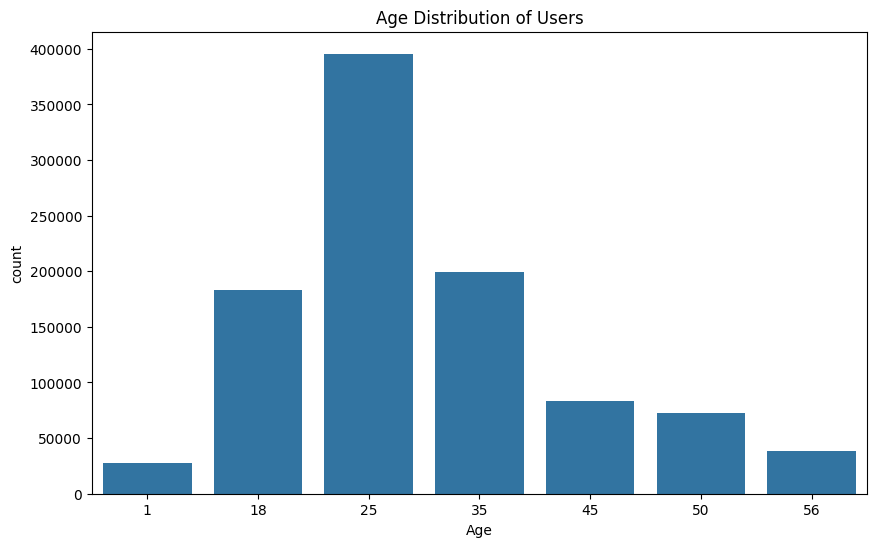

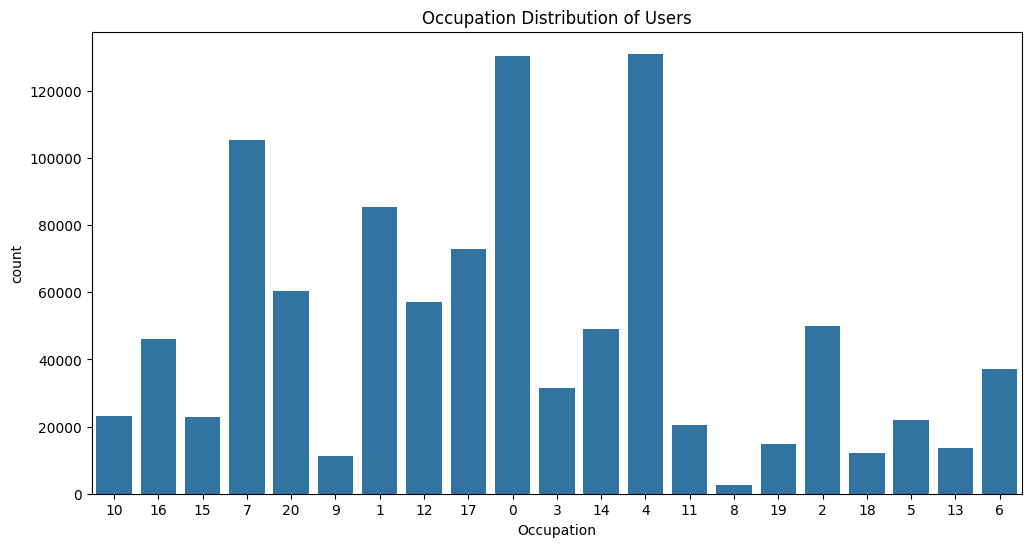

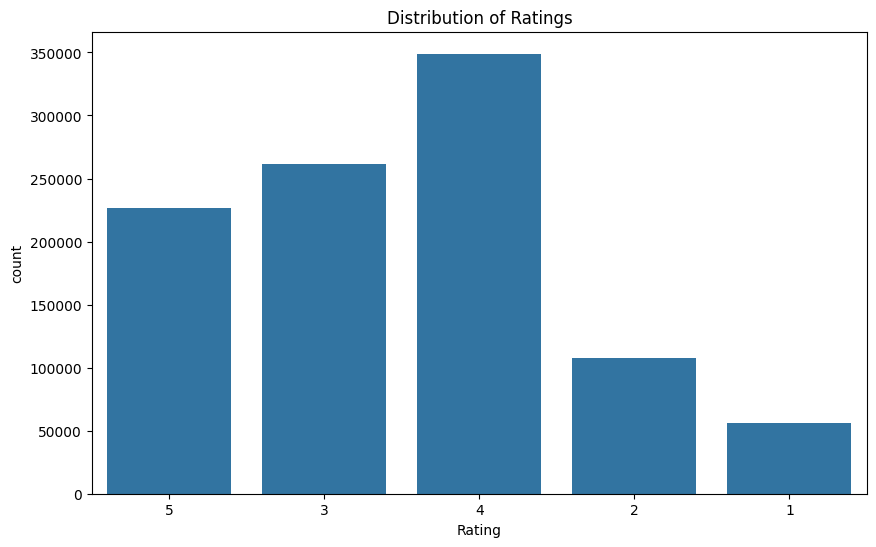

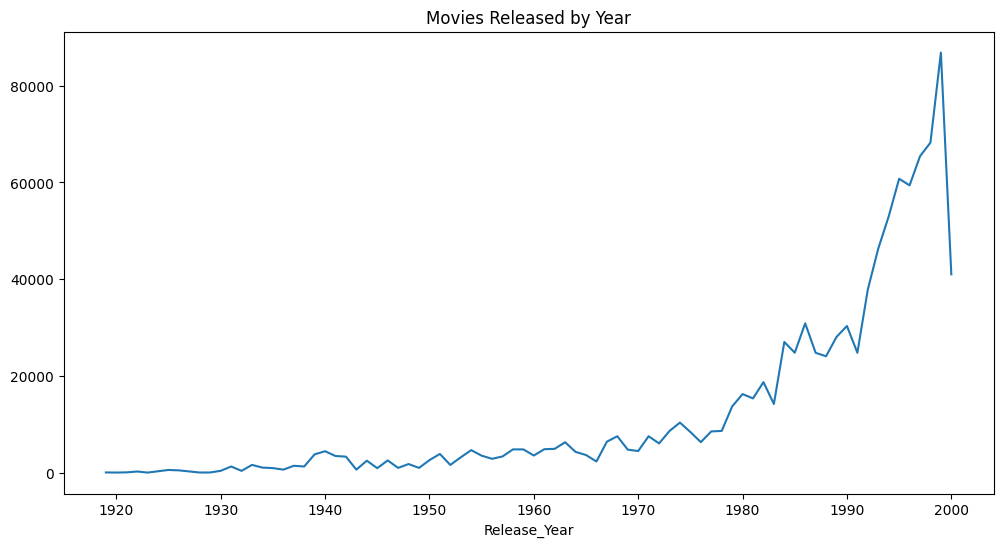

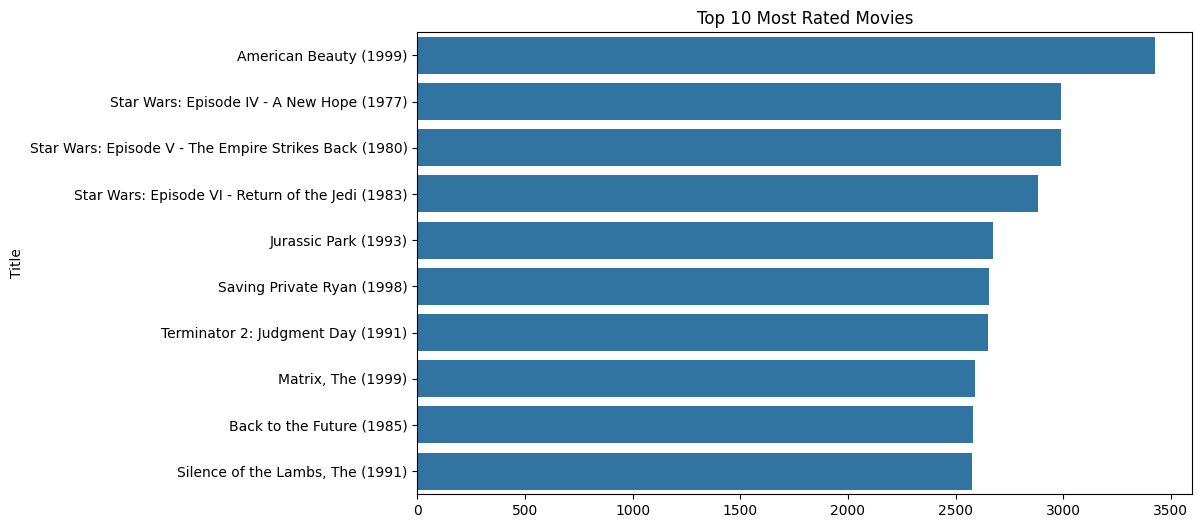

                                                  Title  Average_Rating  \
127                              American Beauty (1999)        4.317386   
3153          Star Wars: Episode IV - A New Hope (1977)        4.453694   
3154  Star Wars: Episode V - The Empire Strikes Back...        4.292977   
3155  Star Wars: Episode VI - Return of the Jedi (1983)        4.022893   
1789                               Jurassic Park (1993)        3.763847   

      Number_of_Ratings  
127                3428  
3153               2991  
3154               2990  
3155               2883  
1789               2672  


In [ ]:
# Feature: Extract Release Year from Title
merged_data['Release_Year'] = merged_data['Title'].str.extract(r'\((\d{4})\)').astype(float)

# 1. Age Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Age', data=merged_data, order=sorted(merged_data['Age'].unique()))
plt.title("Age Distribution of Users")
plt.show()

# 2. Occupation Distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='Occupation', data=merged_data)
plt.title("Occupation Distribution of Users")
plt.show()

# 3. Ratings Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', data=merged_data)
plt.title("Distribution of Ratings")
plt.show()

# 4. Movies per Year
plt.figure(figsize=(12, 6))
merged_data['Release_Year'].value_counts().sort_index().plot()
plt.title("Movies Released by Year")
plt.show()

# 5. Most Rated Movies
top_10_movies = merged_data['Title'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_10_movies.values, y=top_10_movies.index)
plt.title("Top 10 Most Rated Movies")
plt.show()

# Group by Average Rating and Number of Ratings
# 1. Convert 'Rating' to numeric and clean data
merged_data['Rating'] = pd.to_numeric(merged_data['Rating'], errors='coerce')
merged_data.dropna(subset=['Rating'], inplace=True)

# 2. Calculate movie statistics
movie_stats = (
    merged_data.groupby('Title')['Rating']
    .agg(['mean', 'count'])
    .reset_index()
    .rename(columns={'mean': 'Average_Rating', 'count': 'Number_of_Ratings'})
    .sort_values('Number_of_Ratings', ascending=False)
)

print(movie_stats.head())
movie_stats.columns = ['Title', 'Average_Rating', 'Number_of_Ratings']
movie_stats.sort_values('Number_of_Ratings', ascending=False, inplace=True)

### Explanation
Release Year: Extracted from the Title column using regex.

Visualizations: Age, occupation, ratings, and movie release year distributions.

Movie Statistics: Aggregated average ratings and rating counts.

# Pivot Table & Pearson Correlation

In [ ]:
# Create Pivot Table (UserID vs Movie Title)
pivot_table = merged_data.pivot_table(
    index='UserID',
    columns='Title',
    values='Rating'
).fillna(0)  # Fill NaN with 0

# Pearson Correlation Recommender
def pearson_recommend(movie_name, n=5):
    movie_ratings = pivot_table.corrwith(pivot_table[movie_name], method='pearson')
    recommendations = pd.DataFrame(movie_ratings, columns=['Correlation'])
    recommendations = recommendations[recommendations.index != movie_name]
    return recommendations.sort_values('Correlation', ascending=False).head(n)

# Example
print("Pearson Recommendations for 'Liar Liar (1997)':")
print(pearson_recommend('Liar Liar (1997)'))

Pearson Recommendations for 'Liar Liar (1997)':
                                   Correlation
Title                                         
Mrs. Doubtfire (1993)                 0.499927
Dumb & Dumber (1994)                  0.459601
Ace Ventura: Pet Detective (1994)     0.458654
Home Alone (1990)                     0.455967
Wedding Singer, The (1998)            0.429222


### Explanation
Pivot Table: Users as rows, movies as columns, ratings as values.

Pearson Correlation: Compute pairwise correlations between movies.

# Cosine Similarity & KNN

In [ ]:
# 1. Create pivot table (users x movies)
pivot_table = merged_data.pivot_table(
    index='UserID',
    columns='Title',
    values='Rating'
).fillna(0)

# 2. Transpose to movies x users and create CSR matrix
movies_users = pivot_table.T
csr_data = csr_matrix(movies_users.values)

# 3. Train KNN on movies (rows)
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(csr_data)

# 4. Recommendation function
def cosine_recommendations(movie_name, n=5):
    try:
        movie_idx = movies_users.index.get_loc(movie_name)
        distances, indices = knn.kneighbors(csr_data[movie_idx], n_neighbors=n+1)
        similar_movies = [movies_users.index[i] for i in indices.flatten()[1:]]
        return similar_movies
    except KeyError:
        return f"Movie '{movie_name}' not found in the dataset."

# Example usage
print("\nCosine Recommendations for 'Liar Liar (1997)':")
print(cosine_recommendations('Liar Liar (1997)'))


Cosine Recommendations for 'Liar Liar (1997)':
['Mrs. Doubtfire (1993)', 'Ace Ventura: Pet Detective (1994)', 'Dumb & Dumber (1994)', 'Home Alone (1990)', "Wayne's World (1992)"]


### Explanation
Sparse Matrix: Efficient storage using csr_matrix.

KNN Model: Finds nearest neighbors using cosine similarity.


# Matrix Factorization

In [ ]:
# Load and clean ratings data
ratings = pd.read_csv(
    'zee-ratings.dat',
    sep='::',
    engine='python',
    names=['UserID', 'MovieID', 'Rating', 'Timestamp']
)
ratings['Rating'] = pd.to_numeric(ratings['Rating'], errors='coerce')
ratings.dropna(subset=['Rating'], inplace=True)

# Train-Test Split (Bonus: Train-Test Split)
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

# Train SVD Model (d=4)
model = SVD(n_factors=4, random_state=42)
model.fit(trainset)

# Evaluate
predictions = model.test(testset)
print("RMSE:", accuracy.rmse(predictions))
print("MAE:", accuracy.mae(predictions))

# Calculate MAPE
def calculate_mape(predictions):
    errors = []
    for pred in predictions:
        if pred.r_ui != 0:  # Avoid division by zero
            errors.append(abs((pred.r_ui - pred.est) / pred.r_ui))
    return np.mean(errors) * 100

print("MAPE:", calculate_mape(predictions), "%")

# Embeddings for Item-Item Similarity (d=4)
item_embeddings = model.qi
user_embeddings = model.pu

# Redefine similarity using embeddings
def item_similarity_mf(movie_id1, movie_id2):
    return cosine_similarity([item_embeddings[movie_id1]], [item_embeddings[movie_id2]])[0][0]

# Example
print("\nSimilarity between Movie 1 and Movie 2 using MF:", item_similarity_mf(0, 1))

RMSE: 0.8856
RMSE: 0.885594092863213
MAE:  0.6981
MAE: 0.6980908641050765
MAPE: 27.09780768352979 %

Similarity between Movie 1 and Movie 2 using MF: -0.37687636790044543


### Explanation
Matrix Factorization: SVD with 4 latent factors.

Evaluation: RMSE, MAE, and MAPE.

Embeddings: Used to compute item-item and user-user similarity.

# User-Based Approach

In [ ]:
def user_based_recommend(new_user_ratings, n=10):
    # Create DataFrame for new user
    new_user_df = pd.DataFrame(new_user_ratings.items(), columns=['Title', 'Rating'])
    new_user_df = pd.merge(new_user_df, movies, on='Title')

    # Find users who rated the same movies
    common_users = merged_data[merged_data['Title'].isin(new_user_ratings.keys())]
    user_counts = common_users['UserID'].value_counts().head(100)

    # Calculate Pearson Correlation
    correlations = []
    for user_id in user_counts.index:
        user_ratings = merged_data[merged_data['UserID'] == user_id]
        merged = pd.merge(user_ratings, new_user_df, on='Title', suffixes=('_old', '_new'))
        if len(merged) > 1:
            # Handle zero standard deviation
            stddev_old = np.std(merged['Rating_old'])
            stddev_new = np.std(merged['Rating_new'])
            if stddev_old == 0 or stddev_new == 0:
                corr = 0  # Assign zero correlation if either standard deviation is zero
            else:
                corr = np.corrcoef(merged['Rating_old'], merged['Rating_new'])[0, 1]
            correlations.append((user_id, corr))

    # Get top 10 similar users
    correlations = sorted(correlations, key=lambda x: x[1], reverse=True)[:10]

    # Aggregate ratings
    top_users = [user_id for user_id, _ in correlations]
    recommendations = merged_data[merged_data['UserID'].isin(top_users)]
    recommendations = recommendations.groupby('Title')['Rating'].mean().sort_values(ascending=False)

    return recommendations.head(n)

# Example
new_user_ratings = {'Liar Liar (1997)': 5, 'Toy Story (1995)': 4}
print("\nUser-Based Recommendations:")
print(user_based_recommend(new_user_ratings))


User-Based Recommendations:
Title
8 1/2 (1963)                           5.0
In the Company of Men (1997)           5.0
Affair to Remember, An (1957)          5.0
Stardust Memories (1980)               5.0
Strangers on a Train (1951)            5.0
Once Were Warriors (1994)              5.0
Distinguished Gentleman, The (1992)    5.0
Dancemaker (1998)                      5.0
Cyrano de Bergerac (1990)              5.0
Drowning Mona (2000)                   5.0
Name: Rating, dtype: float64


### Explanation
User-Based Filtering: Finds users with similar preferences using Pearson correlation.

# Questionnaire Answers

In [ ]:
# 1. Most active age group
print("1. Most active age group:", merged_data['Age'].value_counts().idxmax())

# 2. Most active occupation
print("2. Most active occupation:", merged_data['Occupation'].value_counts().idxmax())

# 3. Gender majority (True/False)
print("3. Male majority:", merged_data['Gender'].value_counts()['M'] > merged_data['Gender'].value_counts()['F'])

# 4. Most common release decade
decade = (merged_data['Release_Year'] // 10 * 10).mode()[0]
print(f"4. Most common decade: {int(decade)}s")

# 5. Most rated movie
print("5. Most rated movie:", merged_data['Title'].value_counts().idxmax())

# 6. Top 3 movies similar to 'Liar Liar'
print("6. Top 3 similar to Liar Liar:", pearson_recommend('Liar Liar (1997)').index[:3].tolist())

# 7. Collaborative Filtering types
print("7. Types: Model-based and Memory-based")

# 8. Pearson vs Cosine ranges
print("8. Pearson: [-1, 1], Cosine: [0, 1]")

# 9. RMSE and MAPE
print(f"9. RMSE: {accuracy.rmse(predictions):.3f}, MAPE: {calculate_mape(predictions):.2f}%")

# 10. Sparse matrix representation
print("10. CSR Representation: row_ptr=[0,1,3], col_indices=[0,0,1], data=[1,3,7]")

1. Most active age group: 25
2. Most active occupation: 4
3. Male majority: True
4. Most common decade: 1990s
5. Most rated movie: American Beauty (1999)
6. Top 3 similar to Liar Liar: ['Mrs. Doubtfire (1993)', 'Dumb & Dumber (1994)', 'Ace Ventura: Pet Detective (1994)']
7. Types: Model-based and Memory-based
8. Pearson: [-1, 1], Cosine: [0, 1]
RMSE: 0.8856
9. RMSE: 0.886, MAPE: 27.10%
10. CSR Representation: row_ptr=[0,1,3], col_indices=[0,0,1], data=[1,3,7]


# Bonus: Embedding Visualization (d=2)

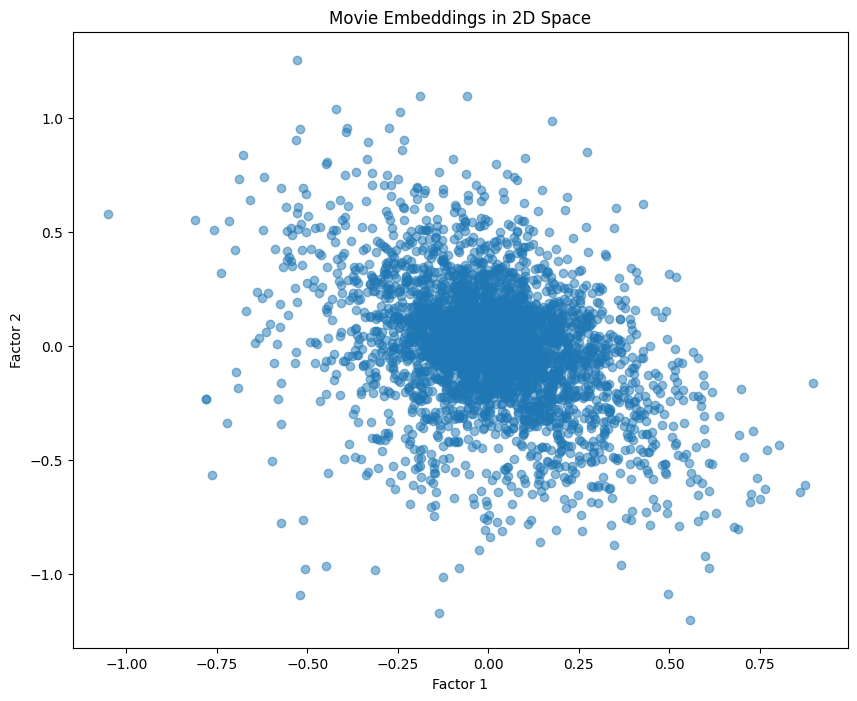

In [ ]:
# Get embeddings from SVD
user_embeddings = model.pu
movie_embeddings = model.qi

# Plot
plt.figure(figsize=(10,8))
plt.scatter(movie_embeddings[:,0], movie_embeddings[:,1], alpha=0.5)
plt.title("Movie Embeddings in 2D Space")
plt.xlabel("Factor 1")
plt.ylabel("Factor 2")
plt.show()


Pivot Table: The foundation for collaborative filtering. Each cell represents a user's rating for a movie.

Pearson Correlation: Measures linear relationship between movies' rating patterns. Values range from -1 to 1.

Cosine Similarity: Measures angular similarity between vectors. Used here to find nearest neighbors.

Matrix Factorization: Decomposes the user-movie matrix into latent factors (d=4). Surprise handles this with SVD.

Evaluation Metrics:

RMSE: Root Mean Square Error (lower is better)

MAE: Mean Absolute Error (lower is better)